# saturationAnalysis.ipynb
## Marcus Viscardi,    September 06, 2024

Taking ques from [subsamplingReadsVsProteinCoding.ipynb](../polyA_manuscriptPostReviewScripts/subsamplingReadsVsProteinCoding.ipynb) which came from the polyA paper and [README.md](../deadenylationPaperFigureUpdates/README.md) which details the stuff from the previous reviews

The important add here is wanting to include the RNA-Seq libraries as a comparison against the nanopore libs. This will be a little annoying as I'll probably want to just use the gene_counts from the RNA-Seq data. In order to subsample gene counts I'll need to expand the stuff out and then back down. If we can do this I could also use the compressed on genes library from nanopore libs!

In [2]:
from typing import Tuple

import nanoporePipelineCommon as npCommon

import numpy as np
import pandas as pd

from pprint import pprint

import re

import seaborn as sea
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from tqdm.auto import tqdm

from icecream import ic
from datetime import datetime

from pathlib import Path

from scipy.stats import mannwhitneyu, ks_2samp

import pickle as pkl

import random

pd.set_option('display.width', 200)
pd.set_option('display.max_columns', None)

def __time_formatter__():
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    return f"ic: {now} | > "
ic.configureOutput(prefix=__time_formatter__)

_ = ic("Imports done!")

ic: 2024-09-16 08:50:09 | > 'Imports done!'


In [3]:
rna_seq_dir = Path("/data16/joshua/working/240829_ESRNA-seqDESeq2")
libs_text_files = rna_seq_dir / "240829_libsFile.txt"
counts_file = rna_seq_dir / "240829_counts_AS.geneCt"
assert libs_text_files.exists()
assert counts_file.exists()
counts_file

PosixPath('/data16/joshua/working/240829_ESRNA-seqDESeq2/240829_counts_AS.geneCt')

In [4]:
libs_dir_dict = {}
libs_sample_dict = {}
rev_libs_sample_dict = {}
with open(libs_text_files, 'r') as f:
    for line in f:
        samp, lib, path = line.strip().split()
        if f"{lib}_1" not in rev_libs_sample_dict:
            rev_libs_sample_dict[f"{lib}_1"] = samp
            lib = lib + "_1"
        elif f"{lib}_2" not in rev_libs_sample_dict:
            rev_libs_sample_dict[f"{lib}_2"] = samp
            lib = lib + "_2"
        elif f"{lib}_3" not in rev_libs_sample_dict:
            rev_libs_sample_dict[f"{lib}_3"] = samp
            lib = lib + "_3"
        libs_sample_dict[samp] = lib
        libs_dir_dict[lib] = Path(path)
pprint(libs_sample_dict)

{'SES26': 'wt_1',
 'SES30': 'smg1_1',
 'SES31': 'smg2_1',
 'SES32': 'smg3_1',
 'SES33': 'smg4_1',
 'SES34': 'smg5_1',
 'SES35': 'smg6_1',
 'SES36': 'smg7_1',
 'SES57': 'smg1_2',
 'SES58': 'smg2_2',
 'SES59': 'smg3_2',
 'SES60': 'smg4_2',
 'SES61': 'smg5_2',
 'SES62': 'smg6_2',
 'SES63': 'smg7_2',
 'SES64': 'wt_2'}


In [5]:
counts_df = pd.read_csv(counts_file, sep="\t").rename(columns={"Unnamed: 0": "gene_id"})
counts_df.rename(columns=libs_sample_dict, inplace=True)
counts_df.sort_values("wt_1", ascending=False).query("wt_1 > 0").head(50)

,gene_id,wt_1,smg1_1,smg2_1,smg3_1,smg4_1,smg5_1,smg6_1,smg7_1,smg1_2,smg2_2,smg3_2,smg4_2,smg5_2,smg6_2,smg7_2,wt_2
1554,WBGene00001167,99005.0,41480.0,73104.0,61752.0,129708.0,49376.0,37844.0,101969.0,71418.0,47328.0,27923.0,40898.0,50058.0,46113.0,54375.0,24105.0
5715,WBGene00004414,75362.0,68416.0,91999.0,82466.0,120041.0,48916.0,26220.0,68580.0,91231.0,57406.0,36678.0,39646.0,52618.0,35329.0,43769.0,20414.0
10125,WBGene00010964,63833.0,74747.0,79006.0,47032.0,130596.0,40982.0,22416.0,60915.0,56806.0,45609.0,50510.0,66697.0,65521.0,58407.0,65213.0,21196.0
3909,WBGene00004421,59357.0,49494.0,53903.0,42694.0,79847.0,25381.0,17244.0,49895.0,65351.0,30098.0,26605.0,36638.0,44709.0,41459.0,41556.0,19455.0
2943,WBGene00015913,54767.0,40001.0,45775.0,36074.0,58673.0,27230.0,16024.0,60640.0,48043.0,24289.0,16220.0,35921.0,42018.0,41408.0,60966.0,28047.0
9589,WBGene00004492,47214.0,40160.0,40307.0,33764.0,62125.0,21321.0,14284.0,39474.0,27920.0,18765.0,19960.0,22354.0,22116.0,24781.0,27069.0,9966.0
9144,WBGene00010556,46591.0,23642.0,33000.0,31541.0,61856.0,22258.0,17041.0,44415.0,40831.0,20872.0,14027.0,19224.0,25910.0,24360.0,30597.0,13658.0
1003,WBGene00016943,45366.0,34219.0,45626.0,31174.0,65169.0,22601.0,15382.0,46713.0,42113.0,24728.0,19008.0,31377.0,32152.0,31681.0,36540.0,20101.0
1773,WBGene00004476,43886.0,23750.0,34092.0,27113.0,54112.0,19031.0,12860.0,38713.0,54133.0,21992.0,13589.0,21646.0,32107.0,29365.0,27558.0,14689.0
4530,WBGene00004478,42876.0,34743.0,32106.0,28326.0,50618.0,18636.0,12964.0,34550.0,31064.0,17025.0,15783.0,19915.0,23851.0,24628.0,26410.0,12554.0


In [6]:
# This is the secret sauce, to go from a two column df where one of the columns in the count of the other column INTO a single column df with the gene_id repeated the correct number of times

def get_gene_id_series_from_counts_df(counts_df: pd.DataFrame, target_lib: str) -> pd.Series:
    test_df = counts_df.copy()[["gene_id", target_lib]].query(f"{target_lib} > 0")
    return test_df.loc[test_df.index.repeat(test_df[target_lib])].reset_index(drop=True)["gene_id"]

In [7]:
def get_unique_genes_count(subsampled_series: pd.Series) -> int:
    # return len(set(subsampled_series))
    return len(np.unique(subsampled_series))
    # return subsampled_series.nunique()

def subsample_gene_repeats(unsampled_series: pd.Series, target_count: int) -> pd.Series:
    rng = np.random.default_rng()
    return rng.choice(unsampled_series, size=target_count, replace=False)

def get_unique_gene_count_averaged(unsampled_series: pd.Series, target_count: int = 1000, n_repeats: int = 10) -> int:
    unsampled_array = unsampled_series.to_numpy()
    unique_counts = np.empty(n_repeats)
    for i in range(n_repeats):
        subsampled_array = subsample_gene_repeats(unsampled_array, target_count)
        unique_counts[i] = get_unique_genes_count(subsampled_array)
    return np.mean(unique_counts)

test_lib = get_gene_id_series_from_counts_df(counts_df, "wt_1")

In [8]:
libs_to_run = [
    "oldN2",
    # "oldS6",
    "newerN2",
    "newerS6",
    "newerS5",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    # "temp25cN2",
    # "temp25cS5",
    # "temp25cS6",
    # "temp25cS7",
]
obj_dict = {}
compressed_df_dict = {}
for lib in libs_to_run:
    print(f"\nLoading {lib}...", end="")
    obj = npCommon.NanoporeRun(run_nickname=lib, pre_load_items=False)
    obj_dict[lib] = obj
    compressed_df_dict[lib] = obj.load_compressedOnGenes()
    print(" Done!")
    # About 45 seconds total, unless loaded recently which is about 5 seconds


Loading oldN2...Loading 240219_compressedOnGenes.parquet... Done. Loaded 12,642 rows.
 Done!

Loading newerN2...Loading 230327_compressedOnGenes.parquet... Done. Loaded 12,714 rows.
 Done!

Loading newerS6...Loading 230403_compressedOnGenes.parquet... Done. Loaded 13,438 rows.
 Done!

Loading newerS5...Loading 230410_compressedOnGenes.parquet... Done. Loaded 12,407 rows.
 Done!

Loading thirdN2...Loading 230920_compressedOnGenes.parquet... Done. Loaded 12,829 rows.
 Done!

Loading thirdS5...Loading 230920_compressedOnGenes.parquet... Done. Loaded 13,742 rows.
 Done!

Loading thirdS6...Loading 230918_compressedOnGenes.parquet... Done. Loaded 10,789 rows.
 Done!


In [9]:
read_df_dict = {"wt_1": get_gene_id_series_from_counts_df(counts_df, "wt_1"),
                "wt_2": get_gene_id_series_from_counts_df(counts_df, "wt_2"),}
for lib, df in compressed_df_dict.items():
    simplified_count_df = df[["gene_id", "read_hits"]].query("read_hits > 0")
    reads_df = simplified_count_df.loc[simplified_count_df.index.repeat(simplified_count_df["read_hits"])].reset_index(drop=True)["gene_id"]
    read_df_dict[lib] = reads_df

In [10]:
# x_values = np.arange(1_000, 1_500_000, 1_000)
# y_values_dict = {}
# for lib, read_like_df in read_df_dict.items():
#     y_values = []
#     working = True
#     iterator = tqdm(x_values, desc=f"Running for {lib}")
#     for x in iterator:
#         if x >= read_like_df.shape[0]:
#             working = False
#         if working:
#             y_values.append(get_unique_gene_count_averaged(read_like_df, target_count=x, n_repeats=10))
#         else:
#             y_values.append(None)
#     y_values_dict[lib] = y_values

In [11]:
for lib, df in read_df_dict.items():
    print(f"{lib:>10}: {df.shape[0]:>10,}")

      wt_1:  8,304,042
      wt_2:  2,706,311
     oldN2:    570,236
   newerN2:    498,345
   newerS6:    747,575
   newerS5:    407,364
   thirdN2:  1,079,159
   thirdS5:  1,287,341
   thirdS6:    523,169


In [12]:
from joblib import Parallel, delayed
N_REPEATS = 10

def process_library(lib, read_like_df, x_values, with_tqdm=False) -> Tuple[str, np.ndarray]:
    y_values = np.empty(len(x_values), dtype=object)
    cutoff = read_like_df.shape[0]
    if with_tqdm:
        iterator = tqdm(enumerate(x_values), desc=f"Running for {lib}", total=len(x_values))
    else:
        iterator = enumerate(x_values)
    for idx, x in iterator:
        if x >= cutoff:
            y_values[idx] = get_unique_genes_count(read_like_df)
            break
        y_values[idx] = get_unique_gene_count_averaged(read_like_df, target_count=x, n_repeats=N_REPEATS)
    return lib, y_values

# x_values = np.arange(10_000, 10_000_000, 10_000)  # TODO: Maybe try a log of x values, so more points at the lower end and less up high where it matters less?
x_values = np.geomspace(1_000, 10_000_000, 200, dtype=int)
# results = Parallel(n_jobs=-1)(delayed(process_library)(lib, read_like_df, x_values) for lib, read_like_df in tqdm(read_df_dict.items(), desc="Processing Libraries"))
results = []
for lib, read_like_df in read_df_dict.items():
    print(f"{lib} has a total read count of {read_like_df.shape[0]:,}")
    results.append(process_library(lib, read_like_df, x_values, with_tqdm=True))
y_values_dict = {lib: y_values for lib, y_values in results}

wt_1 has a total read count of 8,304,042


Running for wt_1:   0%|          | 0/200 [00:00<?, ?it/s]

wt_2 has a total read count of 2,706,311


Running for wt_2:   0%|          | 0/200 [00:00<?, ?it/s]

oldN2 has a total read count of 570,236


Running for oldN2:   0%|          | 0/200 [00:00<?, ?it/s]

newerN2 has a total read count of 498,345


Running for newerN2:   0%|          | 0/200 [00:00<?, ?it/s]

newerS6 has a total read count of 747,575


Running for newerS6:   0%|          | 0/200 [00:00<?, ?it/s]

newerS5 has a total read count of 407,364


Running for newerS5:   0%|          | 0/200 [00:00<?, ?it/s]

thirdN2 has a total read count of 1,079,159


Running for thirdN2:   0%|          | 0/200 [00:00<?, ?it/s]

thirdS5 has a total read count of 1,287,341


Running for thirdS5:   0%|          | 0/200 [00:00<?, ?it/s]

thirdS6 has a total read count of 523,169


Running for thirdS6:   0%|          | 0/200 [00:00<?, ?it/s]

In [15]:
# We need to save the results so we don't have to re-run this every time!!
values_dict = y_values_dict.copy()
values_dict['x_values'] = x_values

save_dir = Path("./data/saturationAnalysis")
save_dir.mkdir(exist_ok=True, parents=True)
with open(save_dir / "saturationAnalysis.pkl", 'wb') as f:
    pkl.dump(values_dict, f)

   thirdS6:   10,789.0 @    541,587
   thirdS5:   13,742.0 @  1,304,901
   thirdN2:   12,829.0 @  1,084,365
   newerS5:   12,407.0 @    410,265
   newerS6:   13,438.0 @    748,810
   newerN2:   12,714.0 @    517,092
     oldN2:   12,642.0 @    594,113
      wt_2:   15,441.0 @  2,736,439
      wt_1:   15,950.0 @  8,309,941


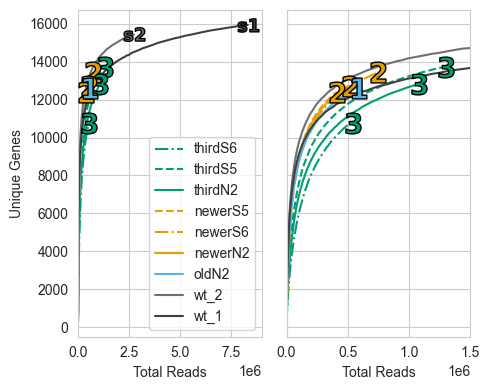

In [16]:
# Let's plot the results:
# y_values on y axis, x_values on x axis:
fig, axes = plt.subplots(1,2, figsize=(5, 4), sharey=True)
# Let's arbitrarily choose colors for each lib in y_values_dict
colors = sea.color_palette("husl", n_colors=len(y_values_dict))
# Maybe let's make a real color and line_style dict:
# WT will be solid lines, smg-5 will be dashed, and smg-6 will be dot-dashed
# RNA-seq will be black and grey, and nanopore reps will be blue, orange, and green for 1, 2, and 3 respectively
# I'd also like the point shapes for the total unique genes to correlate with the line style
solid, dashed, dot_dashed = "-", "--", "-."
# colors_in_255 = ((15, 15, 15), (25, 25, 25), (230, 159, 0), (0, 158, 115), (213, 70, 0))
# grey1, grey2, rep2_color, rep3_color, rep1_color = colors_in_float = [(c[0] / 255, c[1] / 255, c[2] / 255) for c in colors_in_255]
grey1, grey2, rep1_color, rep2_color, rep3_color = "#404040ff", "#707070ff", "#56b4e9ff", "#e69f00ff", "#009e73ff"
color_and_line_style_dict = {
    "wt_1": (grey1,
             solid,
             "$\mathbf{s1}$"),  # RNA-seq 1
    "wt_2": (grey2,
             solid,
             "$\mathbf{s2}$"),  # RNA-seq 2
    "oldN2": (rep1_color,
              solid,
             "$\mathbf{1}$"),  # WT rep 1
    "newerN2": (rep2_color,
                solid,
                "$\mathbf{2}$"),  # WT rep 2
    "thirdN2": (rep3_color,
                solid,
                "$\mathbf{3}$"),  # WT rep 3
    "oldS6": (rep1_color,
              dot_dashed,
             "$\mathbf{1}$"),  # smg-6 rep 1
    "newerS6": (rep2_color,
                dot_dashed,
                "$\mathbf{2}$"),  # smg-6 rep 2
    "thirdS6": (rep3_color,
                dot_dashed,
                "$\mathbf{3}$"),  # smg-6 rep 3
    "oldS5": (rep1_color,
              dashed,
             "$\mathbf{1}$"),  # smg-5 rep 1
    "newerS5": (rep2_color,
                dashed,
                "$\mathbf{2}$"),  # smg-5 rep 2
    "thirdS5": (rep3_color,
                dashed,
                "$\mathbf{3}$"),  # smg-5 rep 3
}

for lib, y_values in list(y_values_dict.items())[::-1]:
    # I need to trim the y_values to get rid of the None values, and make a trimmed version of x_values to match
    trimmed_y_values = np.array([y for y in y_values if y is not None])
    trimmed_x_values = x_values[:len(trimmed_y_values)]
    print(f"{lib:>10}: {trimmed_y_values[-1]:>10,} @ {trimmed_x_values[-1]:>10,}")
    color, line_style, point_shape = color_and_line_style_dict[lib]
    for i, ax in enumerate(axes):
        ax.plot(trimmed_x_values, trimmed_y_values, label=lib, color=color, linestyle=line_style)
        ax.plot(trimmed_x_values[-1], trimmed_y_values[-1], marker=point_shape, color='k', markerfacecolor=color, markersize=15, zorder=10)
for ax in axes[::-1]:
    ax.set_xlabel("Total Reads")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
axes[0].set_xlim(0, 9_000_000)
axes[1].set_xlim(0, 1_500_000)

ax.set_ylabel("Unique Genes")
ax.grid(True, which="both")
ax.legend()
plt.tight_layout()
save_dir = Path("./plots/saturationAnalysis")
save_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(save_dir / "saturationAnalysis.png", dpi=300)
plt.savefig(save_dir / "saturationAnalysis.svg")
plt.show()

In [23]:
N_REPEATS = 10
N_FRACTIONS = 10


def subsample_gene_repeats_fractional(unsampled_series: pd.Series, target_frac: float) -> pd.Series:
    rng = np.random.default_rng()
    target_size = int(len(unsampled_series) * target_frac)
    return rng.choice(unsampled_series, size=target_size, replace=False)

def get_unique_gene_count_averaged_fractional_with_count(unsampled_series: pd.Series, target_frac: float, n_repeats: int = 10) -> Tuple[float, float]:
    unsampled_array = unsampled_series.to_numpy()
    unique_counts = np.empty(n_repeats)
    total_reads = np.empty(n_repeats)
    for i in range(n_repeats):
        subsampled_array = subsample_gene_repeats_fractional(unsampled_array, target_frac)
        total_reads[i] = len(subsampled_array)  # len is about 2x faster than .shape[0] (non-rigorous testing)
        unique_counts[i] = get_unique_genes_count(subsampled_array)
    return np.mean(unique_counts), np.mean(total_reads)

def process_library_fractional(lib: str, read_like_df: pd.Series, fractions: np.array, with_tqdm=False) -> Tuple[str, np.ndarray, np.ndarray]:
    y_values = np.empty(len(fractions), dtype=object)
    total_reads = np.empty(len(fractions), dtype=object)
    if with_tqdm:
        iterator = tqdm(enumerate(fractions), desc=f"Running for {lib}", total=len(fractions))
    else:
        iterator = enumerate(fractions)
    for idx, frac in iterator:
        iterator.set_postfix_str(f"frac: {frac:3.1%}")
        y_values[idx], total_reads[idx] = get_unique_gene_count_averaged_fractional_with_count(read_like_df, target_frac=frac, n_repeats=N_REPEATS)
    return lib, y_values, total_reads

fractions = np.linspace(1 / N_FRACTIONS,  # Start (not 0)
                        1,  # End
                        N_FRACTIONS) # Number of points
results_fractional = []
for lib, read_like_df in read_df_dict.items():
    results_fractional.append(process_library_fractional(lib, read_like_df, fractions, with_tqdm=True))
y_values_dict_fractional = {lib: y_values for lib, y_values, _ in results_fractional}
total_reads_dict_fractional = {lib: total_reads for lib, _, total_reads in results_fractional}

Running for wt_1:   0%|          | 0/10 [00:00<?, ?it/s]

Running for wt_2:   0%|          | 0/10 [00:00<?, ?it/s]

Running for oldN2:   0%|          | 0/10 [00:00<?, ?it/s]

Running for newerN2:   0%|          | 0/10 [00:00<?, ?it/s]

Running for newerS6:   0%|          | 0/10 [00:00<?, ?it/s]

Running for newerS5:   0%|          | 0/10 [00:00<?, ?it/s]

Running for thirdN2:   0%|          | 0/10 [00:00<?, ?it/s]

Running for thirdS5:   0%|          | 0/10 [00:00<?, ?it/s]

Running for thirdS6:   0%|          | 0/10 [00:00<?, ?it/s]

      wt_1:   15,950.0
      wt_2:   15,441.0
     oldN2:   12,642.0
   newerN2:   12,714.0
   newerS6:   13,438.0
   newerS5:   12,407.0
   thirdN2:   12,829.0
   thirdS5:   13,742.0
   thirdS6:   10,789.0


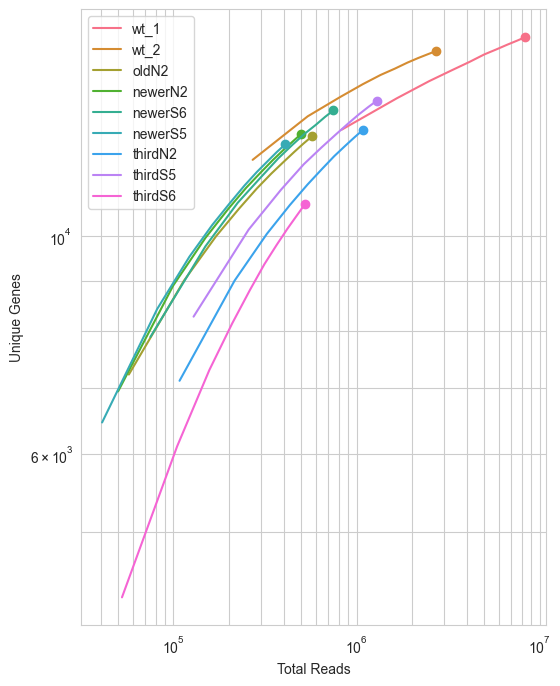

In [38]:
# Let's plot the results:
# y_values on y axis, total_reads on x axis:
fig, ax = plt.subplots(figsize=(6, 8))
# Let's arbirarily choose colors for each lib in y_values_dict_fractional
colors = sea.color_palette("husl", n_colors=len(y_values_dict_fractional))


for idx, (lib, y_values) in enumerate(y_values_dict_fractional.items()):
    print(f"{lib:>10}: {y_values[-1]:>10,}")
    color = colors[idx]
    total_reads = total_reads_dict_fractional[lib]
    ax.plot(total_reads, y_values, label=lib, color=color)
    ax.plot(total_reads[-1], y_values[-1], "o", color=color)
ax.set_xlabel("Total Reads")
ax.set_ylabel("Unique Genes")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(True, which="both")
ax.legend()
plt.show()

In [21]:
# Maybe try to optimize with: the weights option on the pd.DataFrame.sample method
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
# Ideally, I'd do a direct comparison with this super slow method above and the weighted method as discussed in the link
# I think there is some math here where I could sample with weights, then divide the weights by the fraction of the total reads to get the correct number of reads at that depth, then perform a cutoff for >1 reads?
# TODO: Try this out!!

In [ ]:
# Plan:
# 1. Divide the gene counts by the total number of reads to get the fraction of reads for each gene
# 2. Sample with weights based on the fraction of reads (but how many are we sampling? since our rows are genes here, not reads) .... DAMMIT.

# TODO: We should probably do this with rand choice for sampling, as this can take weights and numbers of samples!!